# Demo

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.externals import joblib
from sklearn import metrics
from tqdm import tqdm

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [5]:
raw_documents = []
snippets = []
with open( "data/data.txt", "r") as f:
    for line in f.readlines():
        text = line.strip()
        raw_documents.append( text.lower() )
        
        snippets.append( text[0:min(len(text),100)] )
print("Read %d raw text documents" % len(raw_documents))

Read 4551 raw text documents


In [7]:
# custom stopwords
custom_stop_words = []
with open( "data/stopwords.txt", "r" ) as f:
    for line in f.readlines():
        custom_stop_words.append( line.strip().lower() )
        
print("Stopword list has %d entries" % len(custom_stop_words) )

Stopword list has 350 entries


In [8]:
# create BoW + tf-idf model
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer(stop_words=custom_stop_words, min_df = 20)
A = vectorizer.fit_transform(raw_documents)
print( "Created %d X %d TF-IDF-normalized document-term matrix" % (A.shape[0], A.shape[1]) )

terms = vectorizer.get_feature_names() 

Created 4551 X 10285 TF-IDF-normalized document-term matrix


## apply SVD

In [4]:
# create the model
k = 10
model = TruncatedSVD(n_components=k ) 

W = model.fit_transform( A )
H = model.components_

In [5]:
W.shape

(4551, 10)

In [6]:
W[0,:].round(2)

array([ 0.12, -0.06,  0.03, -0.03,  0.24, -0.1 ,  0.  , -0.04,  0.09,  0.05])

In [7]:
H.shape

(10, 10285)

In [8]:
H[:,terms.index('brexit')].round(2)

array([ 0.09, -0.1 ,  0.19,  0.1 , -0.09, -0.04,  0.01, -0.02, -0.08, -0.  ])

In [9]:
# show topic descriptors
def get_descriptor( terms, H, topic_index, top ):
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms

descriptors = []
for topic_index in range(k):
    descriptors.append( get_descriptor( terms, H, topic_index, 10 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: trump, eu, people, clinton, uk, brexit, campaign, time, vote, film
Topic 02: trump, clinton, republican, donald, hillary, cruz, president, sanders, presidential, campaign
Topic 03: eu, brexit, uk, britain, vote, referendum, leave, european, bank, cameron
Topic 04: league, eu, season, leicester, premier, goal, united, liverpool, ball, city
Topic 05: bank, banks, banking, financial, customers, rbs, shares, deutsche, barclays, lloyds
Topic 06: health, nhs, care, mental, patients, doctors, hospital, people, social, services
Topic 07: album, music, band, song, songs, pop, rock, sound, bowie, guitar
Topic 08: facebook, internet, online, google, twitter, users, media, amazon, company, technology
Topic 09: labour, party, corbyn, bank, cameron, voters, mps, campaign, leader, tory
Topic 10: women, mental, health, abortion, bank, people, men, woman, children, ireland


In [10]:
def get_top_snippets( all_snippets, W, topic_index, top ):
    top_indices = np.argsort( W[:,topic_index] )[::-1]
    top_snippets = []
    for doc_index in top_indices[0:top]:
        top_snippets.append( all_snippets[doc_index] )
    return top_snippets

topic_snippets = get_top_snippets( snippets, W, 0, 10 )
for i, snippet in enumerate(topic_snippets):
    print("%02d. %s" % ( (i+1), snippet ) )

01. Obama talks trans bathroom access as Trump defends business practices – as it happened Here are the 
02. Melania Trump defends husband's 'boy talk' in CNN interview – as it happened Speaking to CNN’s Ander
03. Hillary Clinton: 'I'm sick of the Sanders campaign's lies' – as it happened One of the most importan
04. Donald Trump hits delegate count needed for Republican nomination – as it happened On the one hand, 
05. Clinton seizes on Trump tweets for day of campaigning in Florida – as it happened Donald Trump was a
06. Trump wins Washington primary as protests erupt by Albuquerque rally – as it happened Donald Trump w
07. DNC 2016, day three: emotional Obama passes baton to Clinton – as it happened The sun has set on day
08. Trump campaign reportedly vetting Christie, Gingrich as potential running mates – as it happened Don
09. Donald Trump: money raised by Hillary Clinton is 'blood money' – as it happened Hillary Clinton deli
10. Donald Trump: Hillary Clinton has 'no right to be r

### Topic Coherence

In [11]:
kmin, kmax = 4, 15

topic_models = []
for k in tqdm(range(kmin,kmax+1)):
    model = TruncatedSVD(n_components=k ) 
    W = model.fit_transform( A )
    H = model.components_    
    topic_models.append( (k,W,H) )

100%|██████████| 12/12 [00:02<00:00,  4.62it/s]


In [13]:
import gensim

w2v_model = gensim.models.Word2Vec.load("w2v-model.bin")
print( "Model has %d terms" % len(w2v_model.wv.vocab) )

Model has 12192 terms


Calculate topic coherence TC-W2C as a mean pairwise similarity of words from topic. 

In [14]:
from itertools import combinations


def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)


k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

K=04: Coherence=0.3597
K=05: Coherence=0.4041
K=06: Coherence=0.4062
K=07: Coherence=0.4393
K=08: Coherence=0.4438
K=09: Coherence=0.4340
K=10: Coherence=0.4250
K=11: Coherence=0.4124
K=12: Coherence=0.4062
K=13: Coherence=0.3967
K=14: Coherence=0.4035
K=15: Coherence=0.3804


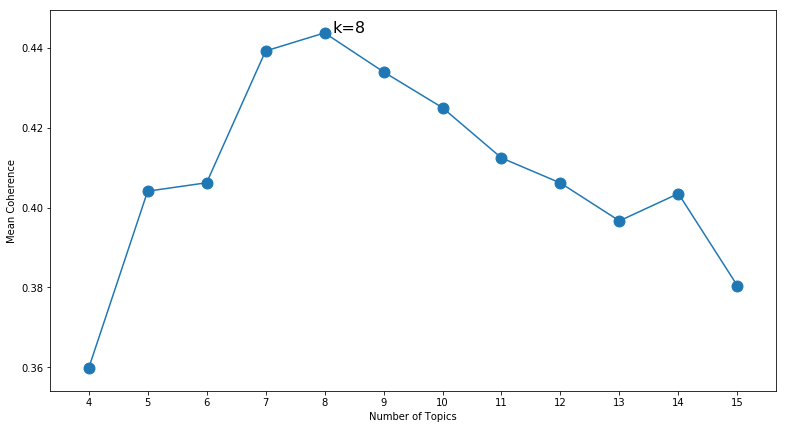

In [15]:
fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

In [16]:
k = best_k
# get the model that we generated earlier.
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]

for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10 )
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: trump, eu, people, clinton, uk, brexit, campaign, time, vote, film
Topic 02: trump, clinton, republican, donald, hillary, cruz, president, sanders, presidential, campaign
Topic 03: eu, brexit, uk, britain, vote, referendum, leave, european, bank, cameron
Topic 04: league, eu, season, leicester, premier, goal, united, liverpool, ball, city
Topic 05: bank, banks, banking, financial, customers, rbs, shares, deutsche, barclays, lloyds
Topic 06: health, nhs, care, mental, patients, doctors, hospital, people, social, services
Topic 07: album, music, song, band, songs, pop, rock, bowie, sound, guitar
Topic 08: facebook, internet, online, google, twitter, users, media, amazon, company, technology
